In [1]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 451 kB 51.3 MB/s 
     |████████████████████████████████| 7.6 MB 36.3 MB/s 
     |████████████████████████████████| 182 kB 18.9 MB/s 
     |████████████████████████████████| 115 kB 64.4 MB/s 
     |████████████████████████████████| 212 kB 54.0 MB/s 
     |████████████████████████████████| 127 kB 67.4 MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделями трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config, get_cosine_schedule_with_warmup
from datasets import load_dataset

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Чтобы сохранять результаты в свою папку на Google disk
%cd ./drive/MyDrive/DLS_NLP/6w_transformers/

/content/drive/MyDrive/DLS_NLP/6w_transformers


Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [7]:
emotion_dataset = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [8]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

In [ ]:
# Уникальные метки в train
np.unique(emotion_dataset["train"]["label"])

array([0, 1, 2, 3, 4, 5])

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [9]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [9]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [25]:
# Если надо, попрактикуйся работать с токенайзером здесь

tok_out = tokenizer.encode_plus(
        emotion_dataset["train"]["text"][0], 
        max_length=7, # максимальная длина текста
        padding="max_length", # надо ли добавлять паддинг в конце?
        return_tensors="pt", # возвращает pytorch тензоры
    )
print(tokenizer.convert_ids_to_tokens(tok_out['input_ids'][0], skip_special_tokens=False))
print(tokenizer.convert_ids_to_tokens(tok_out['input_ids'][0], skip_special_tokens=True))

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']
['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']


In [10]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(
                                        text, 
                                        max_length=self.max_length,
                                        padding="max_length",
                                        return_tensors="pt",
                                    )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'][0], 
            "mask": tokenizer_output['attention_mask'][0],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [11]:
train_dataset = TweetDataset('train', dataset=emotion_dataset, tokenizer=tokenizer, max_length=128)
valid_dataset = TweetDataset('validation', dataset=emotion_dataset, tokenizer=tokenizer, max_length=128)
test_dataset = TweetDataset('test', dataset=emotion_dataset, tokenizer=tokenizer, max_length=128)

In [12]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [29]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=len(train_dataset.labels)
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_0):,} trainable parameters')

The model has 81,917,184 trainable parameters


In [30]:
model_0.config

GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "output_attentions": true,
  "pad_token_id": 50256,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_pr

Подготовь оптимайзер и критерий:

In [35]:
lr = 2e-4 
num_epochs = 7
optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=len(train_loader), 
                                            num_training_steps=num_epochs * len(train_loader)
                                            )

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [32]:
batch = next(iter(train_loader))
tokens = batch["input_ids"].to(device)
mask = batch["mask"].to(device)

with torch.no_grad():
  output = model_0(input_ids=tokens, attention_mask=mask) # Посмотри на аутпут

In [33]:
# Проверим размеры из dataloader
tokens.shape, mask.shape, batch["target"].shape

(torch.Size([64, 128]), torch.Size([64, 128]), torch.Size([64]))

In [20]:
# Посмотрим, что возвращает модель
len(output), type(output)

(3, transformers.modeling_outputs.SequenceClassifierOutputWithPast)

In [21]:
# Модель возвращает 3 сущности - лосс, логиты, key_values из attention blocks
output.loss, type(output.logits), type(output.past_key_values)

(None, torch.Tensor, tuple)

In [22]:
# Сколько записей past_key_values
len(output.past_key_values)

6

In [23]:
# Количество и размеры первой записи past_key_values (у остальных 5 будут такие же)
len(output.past_key_values[0]), output.past_key_values[0][0].shape, output.past_key_values[0][1].shape

(2, torch.Size([64, 12, 128, 64]), torch.Size([64, 12, 128, 64]))

In [24]:
# Размер логитов ( [batch_size, num_classes])
output.logits.shape

torch.Size([64, 6])

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

Для расчета loss и accuracy будем использовать `output.logits`.

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [36]:
from tqdm.notebook import tqdm

def train(model, train_loader, valid_loader, optimizer, criterion, scheduler, num_epochs, modelname='model0'):
  best_loss = np.inf
  best_acc = 0.0
  train_loss_history = []
  val_loss_history = []
  train_acc_history = []
  val_acc_history = []
  best_loss_poch = None
  best_acc_poch = None
  
  for e in range(num_epochs):
      # Train
      train_loss = 0.0
      train_acc = 0.0
      train_num_objs = 0
      
      model.train()
      for batch in tqdm(train_loader, desc="Train", leave=False):
          optimizer.zero_grad()
          tokens = batch["input_ids"].to(device)
          mask = batch["mask"].to(device)
          target = batch["target"].to(device)

          output = model(input_ids=tokens, attention_mask=mask).logits
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          scheduler.step()
          # Metrics
          train_loss += loss.cpu().item()
          train_acc += (output.argmax(dim=1) == target).cpu().sum()
          train_num_objs += len(target.cpu())

      # update train history
      train_loss /= len(train_loader)
      train_acc /= train_num_objs
      train_loss_history.append(train_loss)
      train_acc_history.append(train_acc)

      # Validation
      val_loss = 0.0
      val_acc = 0.0
      val_num_objs = 0
      
      model.eval()
      with torch.no_grad():
          for batch in tqdm(valid_loader, desc="Validation", leave=False):
              tokens = batch["input_ids"].to(device)
              mask = batch["mask"].to(device)
              target = batch["target"].to(device)
              output = model(input_ids=tokens, attention_mask=mask).logits
              loss = criterion(output, target)

              # Metrics
              val_loss += loss.cpu().item()
              val_acc += (output.argmax(dim=1) == target).cpu().sum()
              val_num_objs += len(target.cpu())

      # update val history
      val_loss /= len(valid_loader)
      val_acc /= val_num_objs
      val_loss_history.append(val_loss)
      val_acc_history.append(val_acc)
      
      # Save best val model (loss):
      if val_loss < best_loss:
        best_loss = val_loss
        best_loss_poch = e
        torch.save(model.state_dict(), f'best-loss-{modelname}.pt')

      # Save best val model (acc):
      if val_acc > best_acc:
        best_acc = val_acc
        best_acc_poch = e
        torch.save(model.state_dict(), f'best-acc-{modelname}.pt')
                 
      print(f"Epoch: {e}",
            f"Train Loss: {train_loss_history[-1]:.5f}",
            f"Train Acc: {train_acc_history[-1]:.5f}",
            f"Valid Loss: {val_loss_history[-1]:.5f}",
            f"Valid Acc: {val_acc_history[-1]:.5f}")
      
  print(f"Best val accuracy: Epoch {best_acc_poch}, Accuracy {best_acc:.5f}")
  print(f"Best val loss: Epoch {best_loss_poch}, Loss {best_loss:.5f}")
  dct_history = {'train_loss_history': train_loss_history,
                 'train_acc_history': train_acc_history,
                 'val_loss_history': val_loss_history,
                 'val_acc_history': val_acc_history 
                }
  # Save last model
  torch.save(model.state_dict(), f'last-{modelname}.pt')
  return model, dct_history

def testing(model, test_loader): 
  test_acc = 0
  test_num_obj = 0
  model.eval()
  with torch.no_grad():
      for batch in tqdm(test_loader,  desc="Test", leave=False):
          tokens = batch["input_ids"].to(device)
          mask = batch["mask"].to(device)
          target = batch["target"].to(device)
          output = model(input_ids=tokens, attention_mask=mask).logits
          test_acc += (output.argmax(dim=1) == target).cpu().sum()
          test_num_obj += len(target.cpu())
  print(f"Test Acc: {test_acc / test_num_obj:.5f}")

In [37]:
modelname = 'model0'
model_0, dct_history = train(model_0, train_loader, valid_loader, optimizer, criterion, scheduler, num_epochs=num_epochs, modelname=modelname)

Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0 Train Loss: 1.42369 Train Acc: 0.44238 Valid Loss: 0.70861 Valid Acc: 0.75850


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.36470 Train Acc: 0.87225 Valid Loss: 0.27751 Valid Acc: 0.89650


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.14063 Train Acc: 0.94550 Valid Loss: 0.28345 Valid Acc: 0.90100


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.06984 Train Acc: 0.97350 Valid Loss: 0.32738 Valid Acc: 0.90300


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.03346 Train Acc: 0.98712 Valid Loss: 0.34914 Valid Acc: 0.90450


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.01895 Train Acc: 0.99294 Valid Loss: 0.35640 Valid Acc: 0.91100


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.01131 Train Acc: 0.99556 Valid Loss: 0.36173 Valid Acc: 0.91300
Best val accuracy: Epoch 6, Accuracy 0.91300
Best val loss: Epoch 1, Loss 0.27751


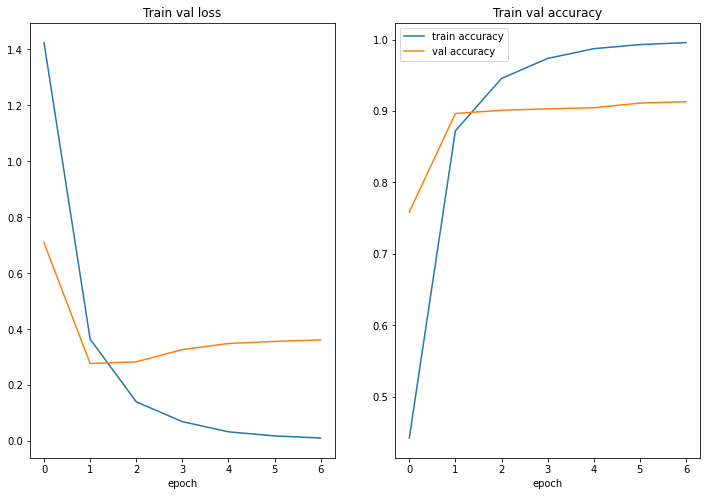

In [38]:
# Построим графики loss и accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ax[0].plot(dct_history['train_loss_history'], label='train loss')
ax[0].plot(dct_history['val_loss_history'], label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Train val loss')
ax[1].plot(dct_history['train_acc_history'], label='train accuracy')
ax[1].plot(dct_history['val_acc_history'], label='val accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Train val accuracy')
plt.legend()            
plt.show()

*Посчитаем accuracy на тестовой датасете. Судя по графикам, разумнее будет использовать ту модель, у которой был меньший лосс. После эпохи с индексом 1 не смотря на рост accuracy лосс на валидации подростал, а модель переобучалась*

In [39]:
# Посчитаем accuracy на тестовом датасете
model_0.load_state_dict(torch.load('best-loss-model0.pt'))
testing(model_0, test_loader)

Test:   0%|          | 0/32 [00:00<?, ?it/s]

Test Acc: 0.89050


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [40]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [41]:
# Shows only one attetntion
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=13)
    ax.set_yticklabels(['']+seq, fontsize=13)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [42]:
# Shows all attentions
def show_attentions(seq, attentions):
  plt.figure(figsize=(20, 10))
  # main color-coded image with labels
  ax=plt.subplot(1, 4, 1)
  ax.matshow(attentions[-1][-1])
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=10)
  ax.set_yticklabels(['']+seq, fontsize=10)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  s = 5
  for i in range(6):
      for j in range(12):
          ax=plt.subplot(6, 16, s + j)
          ax.matshow(attentions[i][j])
          ax.axis('off')
      s += 16

  plt.tight_layout(h_pad=0.1, w_pad=0.1)

In [43]:
text = emotion_dataset["test"]["text"][1000]
tokens = tokenizer.tokenize(text)

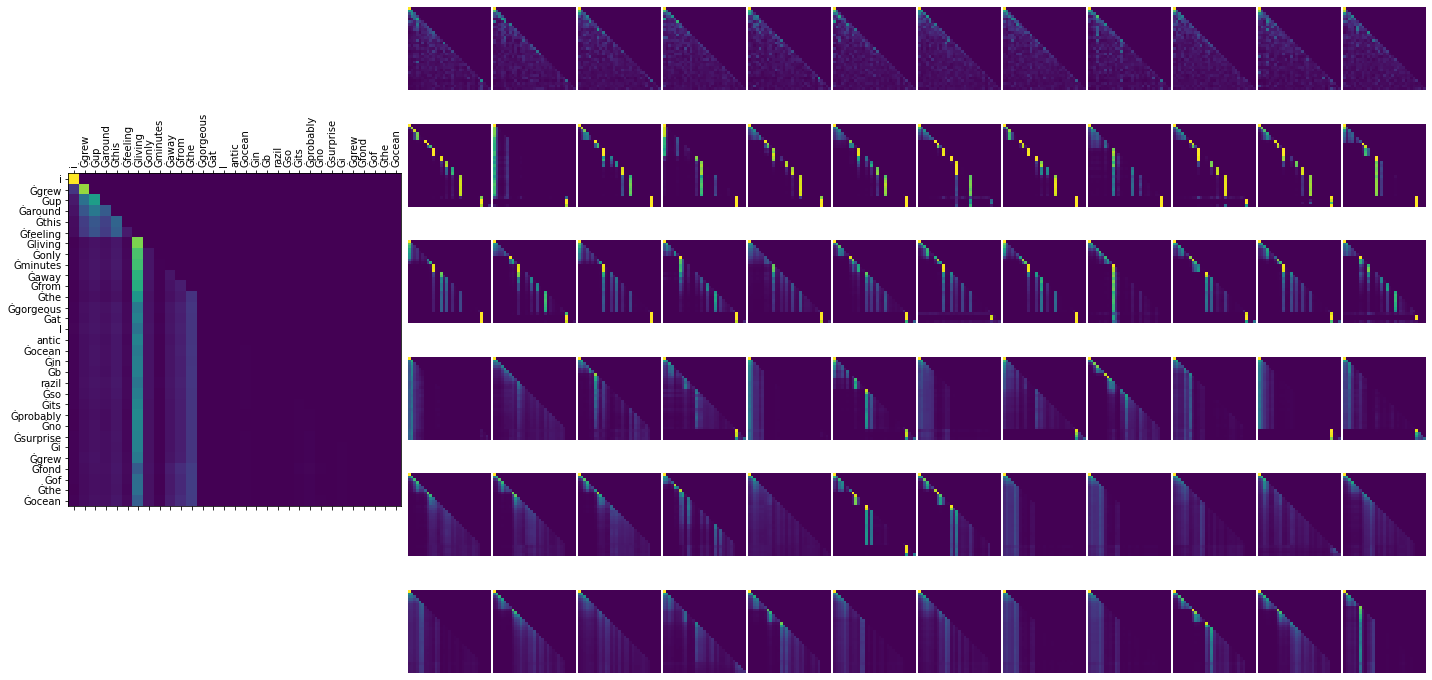

In [44]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attentions(tokens, attns)

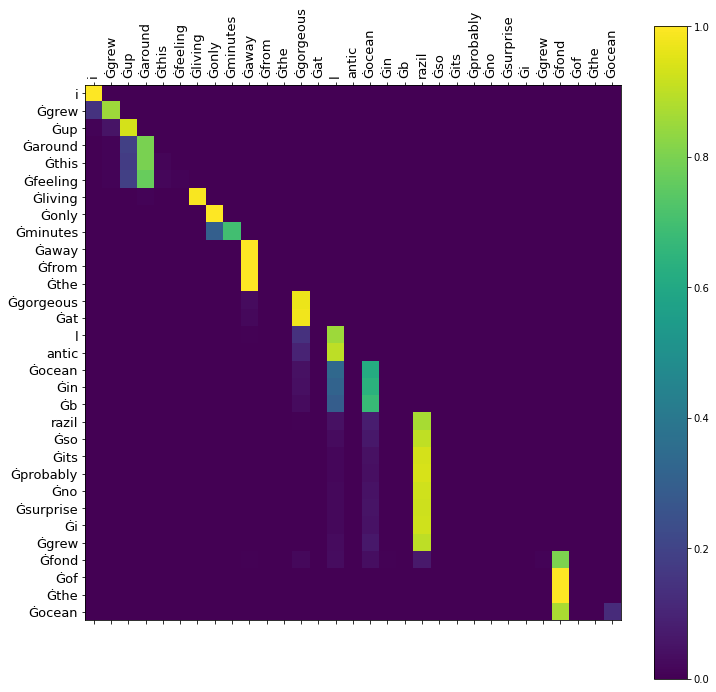

In [45]:
show_attention(tokens, attns[1][0])

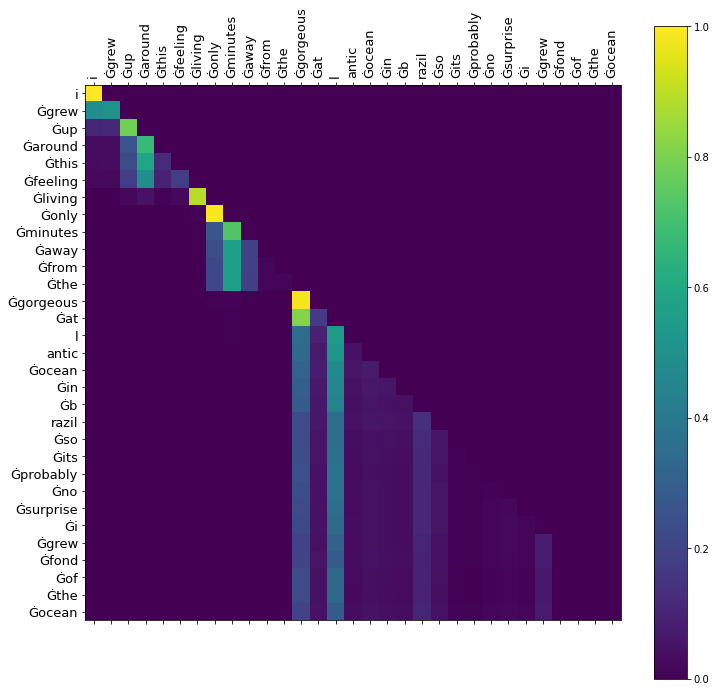

In [46]:
show_attention(tokens, attns[4][6])

In [47]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [49]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=len(train_dataset.labels)
).to(device)

print(f'The model has {count_parameters(model_0):,} trainable parameters')

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model has 81,917,184 trainable parameters


In [ ]:
# Поставим точно такие же параметры
lr = 2e-4 
num_epochs = 10 # поставим 10 эпох, в прошлый раз было 7
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=len(train_loader), 
                                            num_training_steps=num_epochs * len(train_loader)
                                            )

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
modelname='model1'
model_1, dct_history = train(model_1, train_loader, valid_loader, optimizer, criterion, scheduler, num_epochs, modelname)

Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0 Train Loss: 0.82777 Train Acc: 0.69256 Valid Loss: 0.18306 Valid Acc: 0.92650


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.16054 Train Acc: 0.93225 Valid Loss: 0.15574 Valid Acc: 0.92850


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.11657 Train Acc: 0.94500 Valid Loss: 0.12443 Valid Acc: 0.94250


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.09445 Train Acc: 0.95194 Valid Loss: 0.10797 Valid Acc: 0.94150


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.08048 Train Acc: 0.95806 Valid Loss: 0.11422 Valid Acc: 0.93600


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.06788 Train Acc: 0.96513 Valid Loss: 0.11760 Valid Acc: 0.94300


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.05618 Train Acc: 0.97306 Valid Loss: 0.11951 Valid Acc: 0.94100


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.04296 Train Acc: 0.98081 Valid Loss: 0.12482 Valid Acc: 0.94350


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.03348 Train Acc: 0.98537 Valid Loss: 0.12638 Valid Acc: 0.94150


Train:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.03008 Train Acc: 0.98712 Valid Loss: 0.12886 Valid Acc: 0.94000
Best val accuracy: Epoch 7, Accuracy 0.94350
Best val loss: Epoch 3, Loss 0.10797


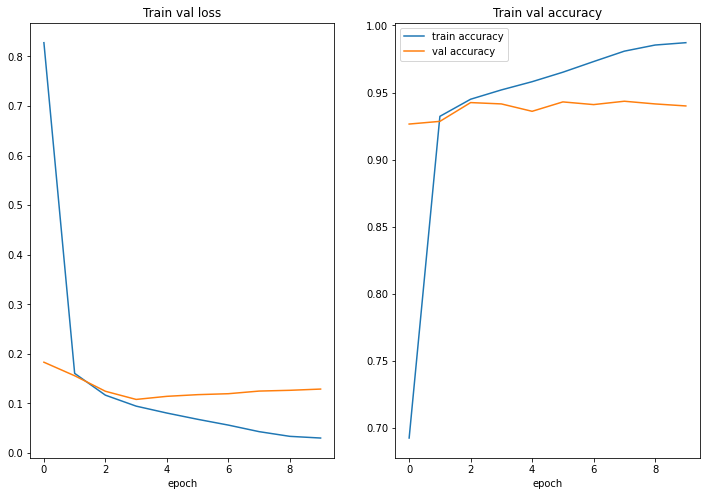

In [ ]:
# Построим графики loss и accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
ax[0].plot(dct_history['train_loss_history'], label='train loss')
ax[0].plot(dct_history['val_loss_history'], label='val loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Train val loss')
ax[1].plot(dct_history['train_acc_history'], label='train accuracy')
ax[1].plot(dct_history['val_acc_history'], label='val accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Train val accuracy')
plt.legend()            
plt.show()

In [50]:
# Посчитаем accuracy на тестовом датасете
model_1.load_state_dict(torch.load('best-loss-model1.pt'))
testing(model_1, test_loader)

Test:   0%|          | 0/32 [00:00<?, ?it/s]

Test Acc: 0.93000


Есть ли прирост качества или скорости обучения?

**Ответ:**
 * Прирост качества есть. 0.93 у второй модели против 0.89 у первой модели
 * Одна эпоха обучения у обоих моделей заняла около 8 минут. Первая модель достигла своего лучшего качества за 2 эпохи, вторая модель за 4 эпохи.


Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [51]:
text = emotion_dataset["test"]["text"][1000]
tokens = tokenizer.tokenize(text)

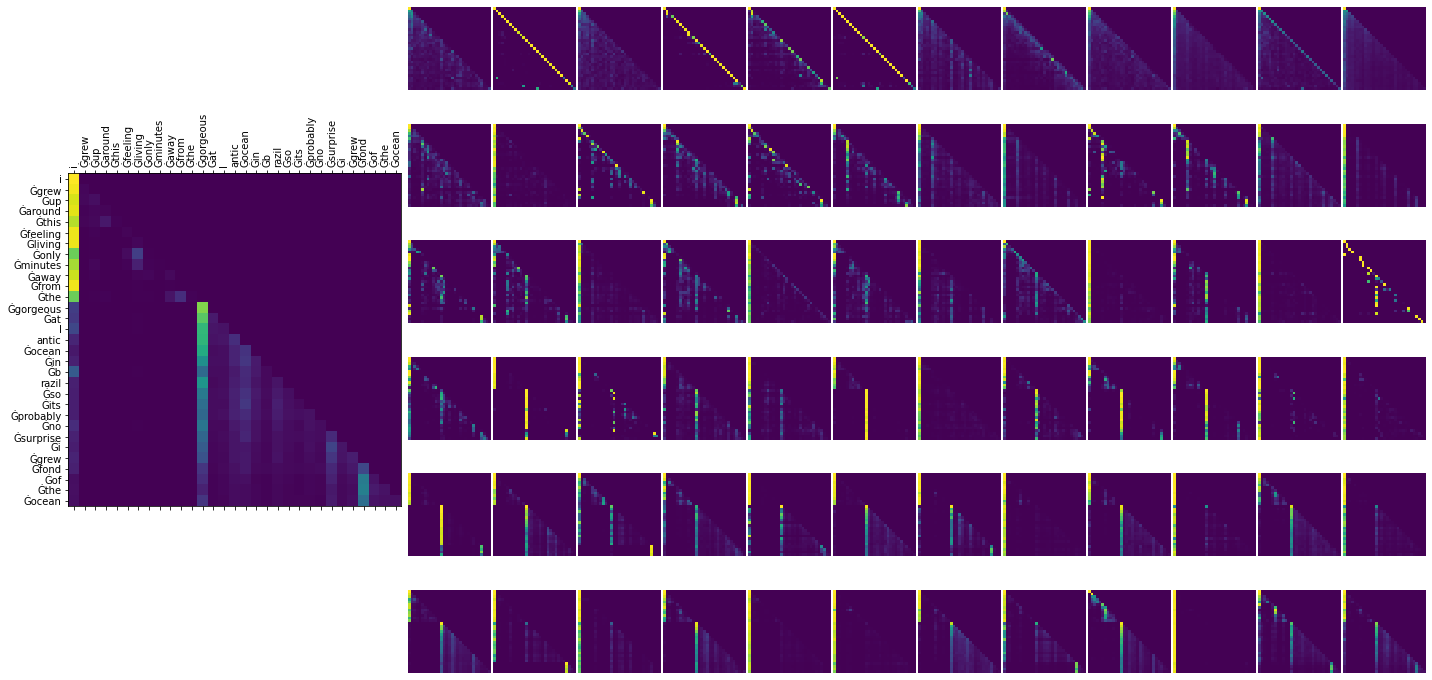

In [52]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attentions(tokens, attns)

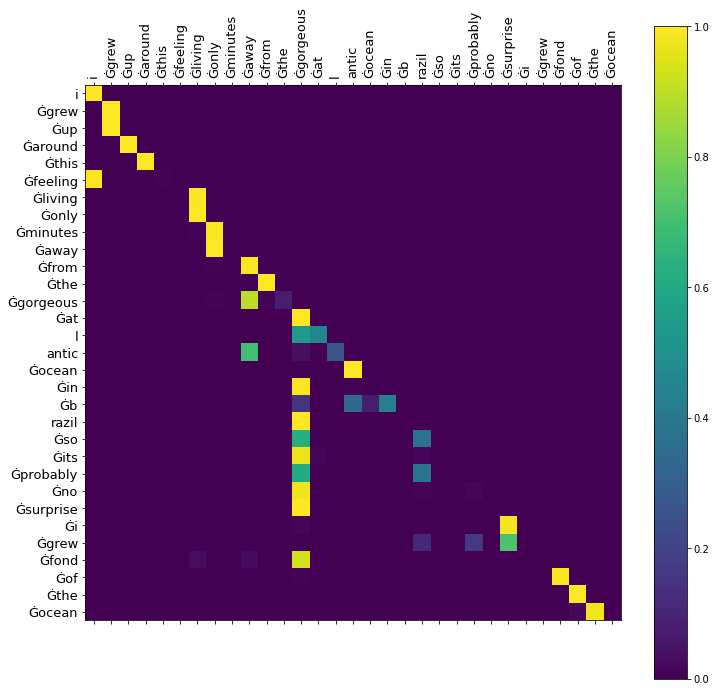

In [37]:
show_attention(tokens, attns[2][-1])

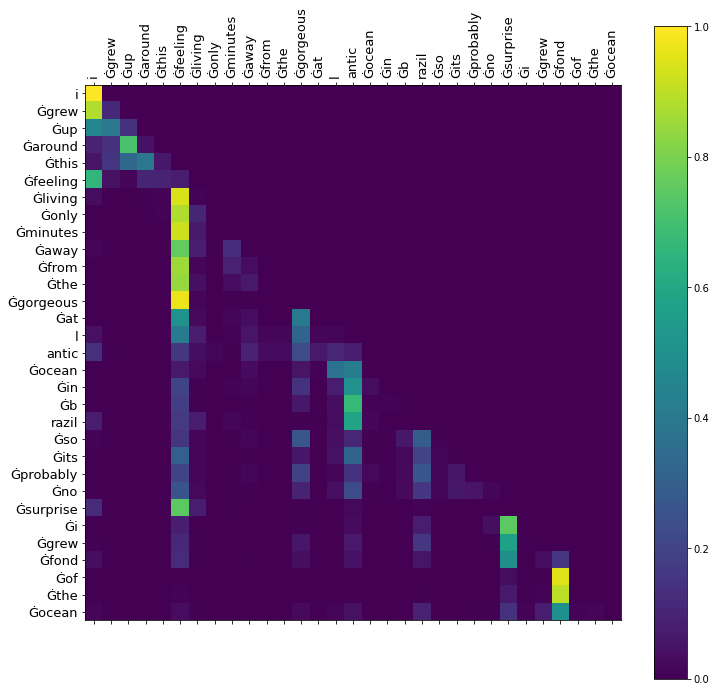

In [38]:
show_attention(tokens, attns[1][9])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?


**Ответ:** 
* Предобученная модель показывает более высокое качество, чем первая модель уже на 0 эпохе (где еще только разогрев происходит). На 2 эпохе accuracy преобученной модели составляет 0.942 (против лучшего качества обучаемой модели = 0.89).
* Обучение с разогревом градиента, кажется, позволяет достичь более высокого качества (чтобы говорить более уверенно, требуется провести больше экспериментов).
* Я посмотрела несколько текстов, все аттеншены (6 слоев х 12 голов) в целом и некоторые в частности. В целом наибольшее внимание уделялось первым словам в предложении. Однако, есть и исключения. Иногда наибольшее внимание уделялось последующим словам или даже последним словам в предложении
* Внимание уделяется словам, которые являются следующей частью слова (например,  b-razil) или связаны логически (например,only-minutes-away-from)
* Кажется, что предобученная модель уделяет внимание более "осознанно" (если можно так выразиться). Первая модель чаще уделяет внимание первой половине предложения, а предобученная модель распределяет внимание более равномерно и чаще смотрит в конец предложения. У предобученной модели часто более концентрированное внимание (больше ярких зон), а у первой модели в основном внимание более рассеянное ("смотрит" везде по-немногу).
* Не уверена, что смогла бы по картам внимания определить, какая модель лучше, если бы не знала качество заранее. Нужно больше практики.